<a href="https://colab.research.google.com/github/ebinjomonkottakal/Computer-Vision-Projects/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

# Utilities

In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image


In [3]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/new_1.jpg https://d2gg9evh47fn9z.cloudfront.net/1600px_COLOURBOX50398267.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget -q -O ./images/itachi.jpg https://w0.peakpx.com/wallpaper/759/390/HD-wallpaper-itachi-uchiha-kakashi-madara-mangekyo-sharingan-minato-sharingan.jpg
print("image files you can choose from: ")
!ls images

image files you can choose from: 
cafe.jpg      itachi.jpg  painting.jpg	swan.jpg
dynamite.jpg  new_1.jpg   rudolph.jpg	tnj.jpg


In [4]:
# set default images
content_path = f'{IMAGE_DIR}/swam.jpg'
style_path = f'{IMAGE_DIR}/new_1.jpg'

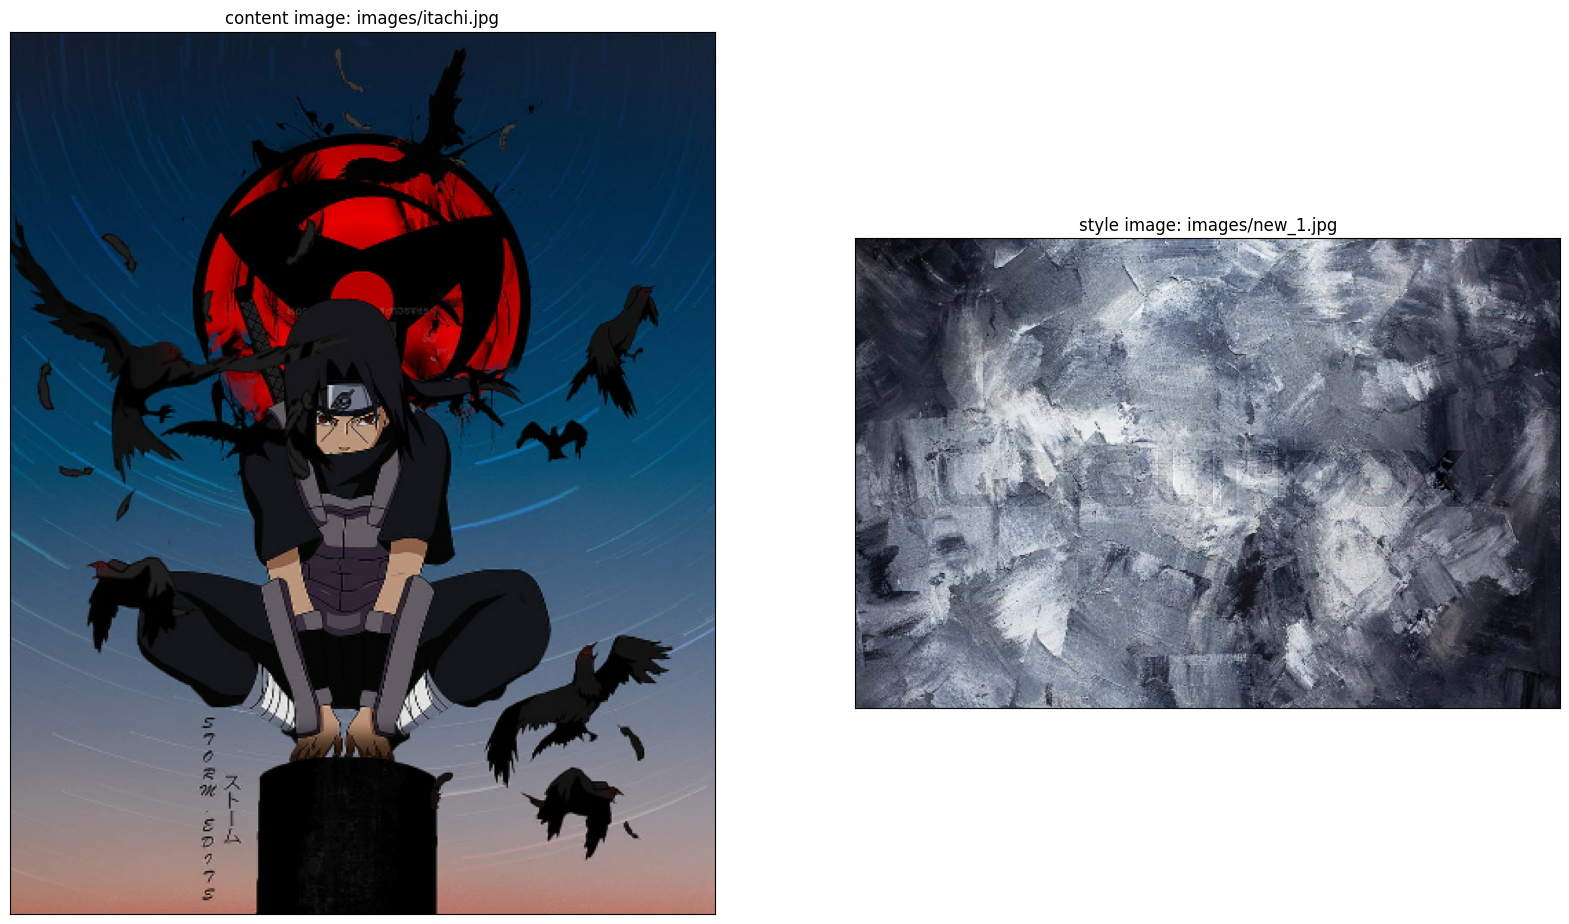

In [5]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Build the model

In [6]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()
# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

574710816/574710816 [==============================] - 25s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
# style layers of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# choose the content layer and put in a list
content_layer = ['block5_conv2']

output_layers = style_layers+content_layer

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layer)
NUM_STYLE_LAYERS = len(style_layers)

In [8]:
def vgg_model(layer_names):
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False,weights = 'imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model(inputs = vgg.input, outputs= outputs)
  return model

In [9]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

vgg = vgg_model(output_layers)
vgg.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# Define Loss Functions

In [10]:
def get_style_loss(features,targets):
  style_loss = tf.reduce_mean(tf.square(features-targets))
  return style_loss

def get_content_loss(features,targets):
  content_loss = 0.5*tf.reduce_mean(tf.square(features-targets))
  return content_loss

In [11]:
def gram_matrix(input_tensor):
  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]
  num_locations = tf.cast(height*width,tf.float32)
  scaled_gram = gram/num_locations
  return scaled_gram

In [12]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

In [13]:
def get_style_image_features(image):
  preprocessed_style_image = preprocess_image(image)
  outputs = vgg(preprocessed_style_image)
  style_outputs = outputs[:NUM_STYLE_LAYERS]
  gram_style_features = [gram_matrix(style_features) for style_features in style_outputs]
  return gram_style_features

def get_content_image_features(image):
  preprocessed_content_image = preprocess_image(image)
  outputs = vgg(preprocessed_content_image)
  content_outputs = outputs[NUM_STYLE_LAYERS:]
  return content_outputs

In [14]:
def get_style_content_loss(style_targets,style_outputs,content_targets,content_outputs,style_weight,content_weight):
  style_loss = tf.add_n([get_style_loss(style_output,style_target)for style_output,style_target in zip(style_outputs,style_targets)])
  content_loss = tf.add_n([get_content_loss(content_output,content_target)for content_output,content_target in zip(content_outputs,content_targets)])
  style_loss = style_loss*style_weight/NUM_STYLE_LAYERS
  content_loss = content_loss*content_weight/NUM_CONTENT_LAYERS
  total_loss = style_loss+content_loss
  return total_loss

In [15]:
def calculate_gradients(image,style_targets,content_targets,style_weight,content_weight,var_weight):
  with tf.GradientTape() as tape:
    style_features = get_style_image_features(image)
    content_features = get_content_image_features(image)
    loss = get_style_content_loss(style_targets,style_features,content_targets,content_features,style_weight,content_weight)
  gradients= tape.gradient(loss,image)
  return gradients

In [16]:
def update_image_with_style(image,style_targets,content_targets,style_weight,var_weight,content_weight,optimizer):
  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  image.assign(clip_image_values(image, min_value = 0.0,max_value=255.0))

In [17]:
def fit_style_transfer(style_image,content_image,style_weight=1e-2,content_weight=1e-4,var_weight=0,optimizer='adam',epochs=1,steps_per_epoch=1):
  images = []
  step = 0
  # get the style image features
  style_targets = get_style_image_features(style_image)

  # get the content image features
  content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
    # collect the image updates starting from the content image
  images.append(content_image)

  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

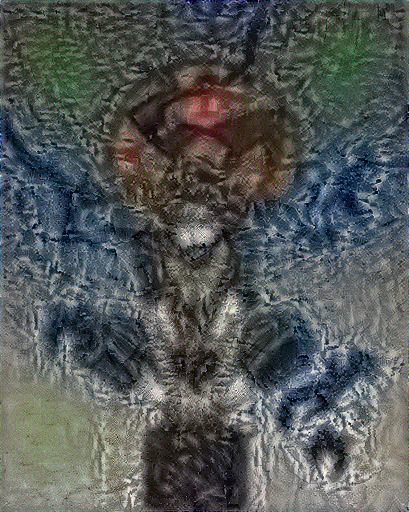

Train step: 1000


In [18]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)